In [136]:
# Напишем интерфейс случайной величины с тремя методами: плотность, функция распределения и квантиль уровня alpha.
from abc import ABC, abstractmethod


class RandomVariable(ABC):
    @abstractmethod
    def pdf(self, x):
        pass

    @abstractmethod
    def cdf(self, x):
        pass

    @abstractmethod
    def quantile(self, alpha):
        pass

In [137]:
# Создадим класс - нормальная случайная величина.
import math

class NormalRandomVariable(RandomVariable):
    def __init__(self, location=0, scale=1) -> None:
        super().__init__()
        self.location = location
        self.scale = scale

    def pdf(self, x):
        z = (x - self.location) / self.scale
        return math.exp(-0.5 * z * z) / (math.sqrt(2 * math.pi) * self.scale)
  
    def cdf(self, x):
        z = (x - self.location) / self.scale;
        if z <= 0:
            return 0.852 * math.exp(-math.pow((-z + 1.5774) / 2.0637, 2.34))
        return 1 - 0.852 * math.exp(-math.pow((z + 1.5774) / 2.0637, 2.34))

    def quantile(self, alpha):
        return self.location + 4.91 * self.scale * (math.pow(alpha, 0.14) - math.pow(1 - alpha, 0.14))

In [138]:
# И еще класс - непараметрическая случайная величина, 
#у которой pdf - гребенка (она не будет использоваться), cdf - э.ф.р, quantile - выборочный квантиль.
class NonParametricRandomVariable(RandomVariable):
    def __init__(self, source_sample) -> None:
        super().__init__()
        self.source_sample = sorted(source_sample)

    def pdf(self, x):
        if x in self.source_sample:
            return float('inf')
        return 0

    @staticmethod
    def heaviside_function(x):
        if x > 0:
            return 1
        else:
            return 0
  
    def cdf(self, x):
        return np.mean(np.vectorize(self.heaviside_function)(x - self.source_sample))
  
    def quantile(self, alpha):
        index = int(alpha * len(self.source_sample))
        return self.source_sample[index]

In [139]:
# Напишем интерфейс для генераторов случайных величин.
class RandomNumberGenerator(ABC):
    def __init__(self, random_variable: RandomVariable):
        self.random_variable = random_variable

    @abstractmethod
    def get(self, N):
        pass

In [140]:
# Реализуем конкретный класс генератора случайных величин на базе квантилей.
import numpy as np


class SimpleRandomNumberGenerator(RandomNumberGenerator):
    def __init__(self, random_variable: RandomVariable):
        super().__init__(random_variable)
    
    def get(self, N):
        us = np.random.uniform(0, 1, N)
        return np.vectorize(self.random_variable.quantile)(us)

In [170]:
# Определим параметр нормального распределения и объем выборки.
# http://www.machinelearning.ru/wiki/index.php?title=%D0%9D%D0%BE%D1%80%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5
location = 0 #@param {type:"number"} коэффициент сдвига
scale = 1 #@param {type:"number"} коэффициент масштаба

N = 50  #@param {type:"integer"}

In [171]:
# Создадим нормальную случайную величину и генератор псевдослучайных величин, 
#подчиняющихся нормальному распределению. Они будут использованы для генерации исходной выборки.
rv = NormalRandomVariable(location, scale)
generator = SimpleRandomNumberGenerator(rv)

In [172]:
# Сгенерируем исходную выборку.
sample = generator.get(N)
sample

array([ 0.53442725,  0.74911993,  0.16873072, -0.88388783, -1.39771244,
       -0.75413573, -0.04527654,  1.2343347 , -0.40561586, -0.56576953,
       -0.89057727, -1.69454013,  0.59955313,  0.20619961,  0.87917981,
       -1.42593075,  0.74040964,  0.33157824, -1.08429472, -0.85369594,
       -0.46344416, -0.01975593, -0.07163708, -1.53289728,  0.9387083 ,
        1.75378855,  0.66384324, -1.66320062, -0.37222659,  0.67892591,
        0.01578195, -0.6182414 , -1.40302403,  0.52841334,  1.0511025 ,
       -0.39664012, -0.80975202, -0.81194117,  0.20828358, -0.68430068,
        0.02057677,  0.25049545,  0.24895251,  0.21376405,  0.11488345,
        0.47150523,  2.49502503,  0.3987677 , -0.70690017,  1.43317996])

In [173]:
# Создадим непараметрическую случайную величину и генератор на базе нее. Он будет использован для генерации ревыборок.
rv1 = NonParametricRandomVariable(sample)
generator1 = SimpleRandomNumberGenerator(rv1)

In [174]:
# Создадим интерфейс наших оценок и реализуем их в конкретных классах.
import numpy as np

class Estimation(ABC):
    @abstractmethod
    def estimate(sample):
        pass


import statistics


class Mean(Estimation):
    def estimate(self, sample):
        return statistics.mean(sample)

class Var(Estimation):
    def estimate(self, sample):
        return statistics.variance(sample)
#========================================================================================
class PearsonTukey(Estimation): # Первая оценка Пирсона-Тьюки
    def estimate(self, sample):
        sorted_sample = np.sort(sample)
        k_1 = int(0.95 * N)
        k_2 = int(0.05 * N)
        k_3 = int(0.5 * N)
        k_4 = int(N / 2)
        delta = sorted_sample[k_1] + sorted_sample[k_2] - 2 * sorted_sample[k_3]
        return sorted_sample[k_4] + 0.185 * delta
    
class SampleMedian(Estimation):  # Вторая оценка выборочная медиана
    def estimate(self, sample):
        sorted_sample = np.sort(sample)
        if (N / 2).is_integer():
            k1 = int(N / 2)
            k2 = int((N / 2 + 1))
            return 0.5 * (sorted_sample[k1] + sorted_sample[k2])
        elif ((N + 1) / 2).is_integer():
            return sorted_sample[int((N + 1) / 2)]

In [175]:
PearsonTukey().estimate(sample)

-0.0054843398529315045

In [176]:
SampleMedian().estimate(sample)

0.06773010820598467

In [177]:
# Выборочное среднее
Mean().estimate(sample)

-0.05251734944514652

In [178]:
# Дисперсия
Var().estimate(sample)

0.8343515823982594

In [179]:
# ОЦЕНКИ ПОСТРОИЛИ. ДАЛЕЕ ИССЛЕДУЕМ ОЦЕНКИ

In [180]:
# Основной класс, который принимает 
#генератор выборок, список оценок, количество ревыборок, 
#которые будут сгенерированы и истинное значение параметра для оценки смещения.

class Modelling(ABC):
    def __init__(self, gen: RandomNumberGenerator, estimations: list, M:int, truth_value:float):
        self.gen = gen
        self.estimations = estimations
        self.M = M
        self.truth_value = truth_value
        
        # Здесь будут храниться выборки оценок
        self.estimations_sample = np.zeros((self.M, len(self.estimations)), dtype=np.float64)
        
    # Метод, оценивающий квадрат смещения оценок
    def estimate_bias_sqr(self):
        return np.array([(Mean().estimate(self.estimations_sample[:,i]) - self.truth_value) ** 2 for i in range(len(self.estimations))])
    
    # Метод, оценивающий дисперсию оценок
    def estimate_var(self):
        return np.array([Var().estimate(self.estimations_sample[:,i]) for i in range(len(self.estimations))])
    
    # Метод, оценивающий СКО оценок
    def estimate_mse(self):
        return self.estimate_bias_sqr() + self.estimate_var()
    
    def get_samples(self):
        return self.estimations_sample
    
    def get_sample(self):
        return self.gen.get(N)
    
    def run(self):
        for i in range(self.M):
            sample = self.get_sample()
            self.estimations_sample[i, :] = [e.estimate(sample) for e in self.estimations]

In [181]:
#Моделируем или бутстрепим в зависимости от генератора выборок.

modelling = Modelling(generator1, [PearsonTukey(), SampleMedian()], 2 * N, location)
modelling.run()

In [182]:
# Оценим СКО оценок

mses = modelling.estimate_mse()
mses

array([0.02443677, 0.03607   ])

In [183]:
# Смотрим во сколько раз вторая оценка хуже первой
mses[1] / mses[0]

1.4760541555534215

In [184]:
# Дисперсия оценок

var = modelling.estimate_var()
var

array([0.024433  , 0.03272377])

In [185]:
# Оценим квадрат смещения оценок

bias_sqr = modelling.estimate_bias_sqr()
bias_sqr

array([3.77644299e-06, 3.34622839e-03])

In [186]:
# Класс для построения оценок плотностей оценок.

class SmoothedRandomVariable(RandomVariable):
    def _k(x):
        if abs(x) <= 1:
            return 0.75 * (1 - x * x)
        else:
            return 0
    def _K(x):
        if x < -1:
            return 0
        elif -1 <= x < 1:
            return 0.5 + 0.75 * (x - x ** 3 / 3)
        else:
            return 1
        
    def __init__(self, sample, h):
        self.sample = sample
        self.h = h
        
    def pdf(self, x):
        return np.mean([SmoothedRandomVariable._k((x - y) / self.h) for y in self.sample]) / self.h
    
    def cdf(self, x):
        return np.mean([SmoothedRandomVariable._K((x - y) / self.h) for y in self.sample])
    
    def quantile(self, alpha):
        raise NotImplementedError

In [187]:
# Зададим значение параметра размытости.

bandwidth = 0.05 #@param {type:"number"}

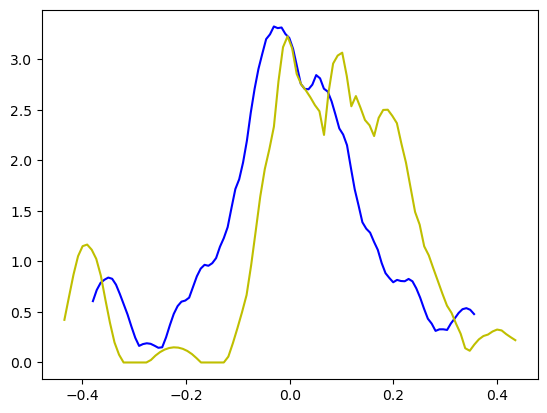

In [188]:
# Нарисуем оценки плотностей.

import matplotlib.pyplot as plt

samples = modelling.get_samples()
POINTS = 100

for i in range(samples.shape[1]):
    sample = samples[:, i]
    X_min = min(sample)
    X_max = max(sample)
    x = np.linspace(X_min, X_max, POINTS)
    srv = SmoothedRandomVariable(sample, bandwidth)
    y = np.vectorize(srv.pdf)(x)
    if i == 0:
        plt.plot(x, y, color='b')
    elif i == 1:
        plt.plot(x, y, color='y')
plt.show()

In [339]:
N = 50

In [340]:
#  Равномерное распределение (НЕ ИСПОЛЬЗУЕТСЯ)
class UniformRandomVariable(RandomVariable):
    def __init__(self, a=0, b=1) -> None:
        super().__init__()
        self.a = a  # нижняя граница области значений
        self.b = b  # верхняя граница области значений

    def pdf(self, x):  # плотность вероятности
        if self.a <= x <= self.b:
            return 1 / (self.b - self.a)
        else:
            return 0

    def cdf(self, x):  # Функция распределения
        if x <= self.a:
            return 0
        elif x >= self.b:
            return 1
        else:
            return (x - self.a) / (self.b - self.a)

    #  Моделирование СВ Х на отрезке [a, b] по формуле ниже
    def quantile(self, alpha):  # alpha -- равномерно-распределенная СВ на [0, 1]
        return alpha * (self.b - self.a) + self.a

In [341]:
# датчик псевдослучайных величин модели выбросов Тьюки
import random

class TukeyRandomNumberGenerator(RandomNumberGenerator):
    def __init__(self, random_variable: RandomVariable, normal_variable: NormalRandomVariable, epsilon):
        super().__init__(random_variable)
        self.epsilon = epsilon
        self.normal_variable = normal_variable

    def get(self, N):
        sample = []
        us = np.random.uniform(0, 1, N)  #  U(0, 1)
        for x in us:
            if 0 <= x <= self.epsilon:  # если значение в промежутке [0, epsilon]
                sample.append(self.normal_variable.quantile(random.random()))  # h
            else:
                sample.append(self.random_variable.quantile(random.random()))  # g
        return sample

In [342]:
rv2 = NormalRandomVariable(0, 10)
generator2 = TukeyRandomNumberGenerator(rv1, rv2, 10)

In [343]:
sample = generator2.get(N)
sample

[-5.963559546598734,
 4.192196352936672,
 -4.694665484182602,
 21.04910608269949,
 -1.3172587196900036,
 -20.018032057757658,
 9.747844174714801,
 -13.487037658646765,
 -12.021840777890603,
 0.13206710825782142,
 7.028482534443406,
 11.757549166181043,
 -0.7515402930760121,
 2.567106528631423,
 -8.346764788845976,
 -19.13076512721734,
 -6.084945073357974,
 -0.6450238835438502,
 4.352160986399212,
 6.161233332039617,
 1.6870456434202454,
 25.98358243648886,
 -7.960736264410018,
 12.90393243217197,
 5.149569774673367,
 -1.4248021394813861,
 7.136112028337622,
 -30.79235845813636,
 19.494536006884427,
 -4.4306546701862155,
 17.983242562818287,
 -7.081297379937471,
 -1.7891440178930644,
 -12.23439562778264,
 6.292290565367915,
 -3.3712571039535177,
 -6.954783079021233,
 14.305154268758749,
 21.95956310873058,
 -4.83308376979957,
 5.258976006403499,
 8.21268371671369,
 -6.218094535789279,
 25.61005690969788,
 14.961596552446125,
 -20.960766142804726,
 3.6399208290471767,
 4.029085965325511,

In [344]:
PearsonTukey().estimate(sample)

1.4220219997847454

In [345]:
SampleMedian().estimate(sample)

2.127076086025834

In [346]:
Mean().estimate(sample)

1.1474222839496482

In [347]:
Var().estimate(sample)

147.99360284229272

In [348]:
modelling1 = Modelling(generator2, [PearsonTukey(), SampleMedian()], 2 * N, location)
modelling1.run()

In [349]:
mses1 = modelling1.estimate_mse()
mses1

array([2.85072168, 3.50323671])

In [350]:
mses1[1] / mses1[0]

1.2288946785356243

In [351]:
bias_sqr1 = modelling1.estimate_bias_sqr()
bias_sqr1

array([0.06486857, 0.32229467])

In [352]:
var1 = modelling1.estimate_var()
var1

array([2.78585311, 3.18094203])

In [353]:
bandwidth = 0.05

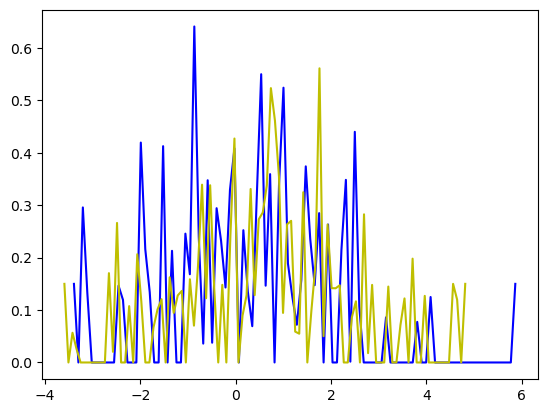

In [354]:
import matplotlib.pyplot as plt

samples = modelling1.get_samples()
POINTS = 100

for i in range(samples.shape[1]):
    sample = samples[:, i]
    X_min = min(sample)
    X_max = max(sample)
    x = np.linspace(X_min, X_max, POINTS)
    srv = SmoothedRandomVariable(sample, bandwidth)
    y = np.vectorize(srv.pdf)(x)
    if i == 0:
        plt.plot(x, y, color='b')
    elif i == 1:
        plt.plot(x, y, color='y')
plt.show()